<div style="background-color:#8f28ff; color:white; padding:10px; border-radius:5px; text-align:center; font-size:20px;">
    MODELING
</div>

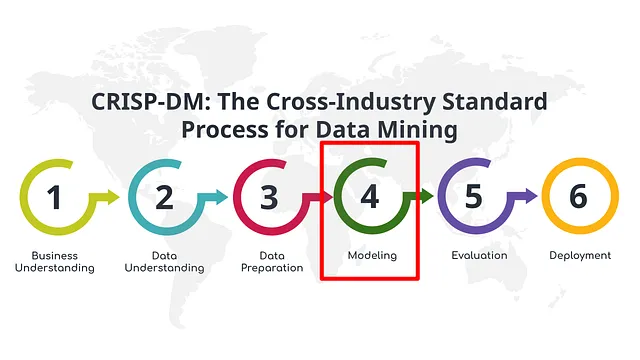

In [1]:
import warnings
import math
import pickle
import warnings

import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import plotly.express          as px
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import xgboost                 as xgb

from sklearn.model_selection       import cross_validate,learning_curve,ShuffleSplit, StratifiedKFold,train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model          import LogisticRegression
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost                       import XGBClassifier
from sklearn.metrics               import roc_curve, ConfusionMatrixDisplay ,auc,accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from scipy.stats                   import uniform, randint
from sklearn.cluster               import KMeans
from sklearn.decomposition         import PCA
from sklearn.preprocessing         import MinMaxScaler
from scipy.spatial.distance        import cdist, pdist
from sklearn.linear_model          import SGDClassifier
from sklearn.datasets              import make_classification

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
custom_params = {"axes.spines.right":False,"axes.spines.top":False}
sns.set_theme(style='ticks',rc=custom_params)
color_palette = ['#8f28ff','#bc7eff','#c0b0d1', '#a1b5db', '#7095db', '#636efa']

sns.set_palette(sns.color_palette(color_palette))
sns.set(rc={"axes.facecolor":"#e8e8e8","figure.facecolor":"#e8e8e8"})
sns.color_palette(color_palette)

[(0.5607843137254902, 0.1568627450980392, 1.0),
 (0.7372549019607844, 0.49411764705882355, 1.0),
 (0.7529411764705882, 0.6901960784313725, 0.8196078431372549),
 (0.6313725490196078, 0.7098039215686275, 0.8588235294117647),
 (0.4392156862745098, 0.5843137254901961, 0.8588235294117647),
 (0.38823529411764707, 0.43137254901960786, 0.9803921568627451)]

In [3]:
df_ = pd.read_csv('df_pad.csv')
out_of_time_data = pd.read_csv('out_of_time_pad.csv')
data_2015_ml = pd.read_csv('data_2015.csv')

<div style="background-color:#8f28ff; color:white; padding:10px; border-radius:5px; text-align:center; font-size:20px;">
    Features
</div>

### Information Value(IV) & Weight of Evidence(WoE)

 - *WOE is a metric that measures the proportional difference between the distribution of two groups: positive and negative events. It transforms a categorical or continuous variable into a logarithmic scale that makes it easier to analyze the strength and direction of the relationship with the target variable.*
   
 - *IV is a metric derived from WOE that quantifies the predictive power of an explanatory variable in relation to the response variable.*

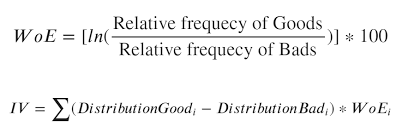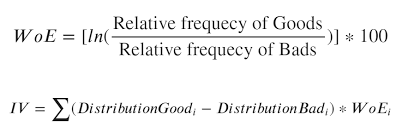

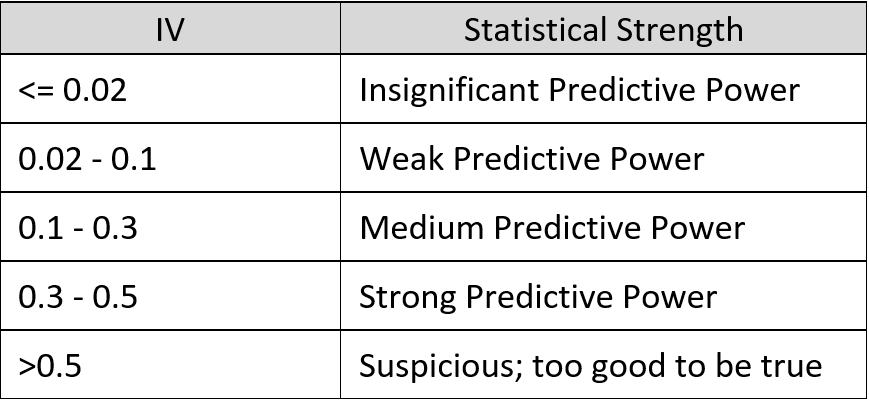

In [4]:
metadados = (df_
             .drop(columns=['data_ref','index','Unnamed: 0'])
             .dtypes
             .to_frame()
             .rename(columns={0:'dtype'})
            )
metadados['missings'] = df_.isna().sum()
metadados['unique_val'] = df_.value_counts()
metadados['unique_val'] = df_.drop(columns=['Unnamed: 0']).nunique()
metadados['papel'] = 'covariate'
metadados.loc['mau','papel'] = 'target'
metadados

,dtype,missings,unique_val,papel
sexo,float64,0,2,covariate
posse_de_veiculo,float64,0,2,covariate
posse_de_imovel,float64,0,2,covariate
qtd_filhos,float64,0,8,covariate
tipo_renda,float64,0,5,covariate
educacao,float64,0,5,covariate
estado_civil,float64,0,5,covariate
tipo_residencia,float64,0,6,covariate
idade,float64,0,47,covariate
tempo_emprego,float64,0,3621,covariate


In [5]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [6]:
for var in metadados[metadados.papel=='covariate'].index:
    if  (metadados.loc[var, 'unique_val']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_[var],5,duplicates='drop'), df_.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df_[var], df_.mau)


In [7]:
metadados['Power_'] = metadados['IV'].apply(lambda x: 'useless' if x <= 0.02 else 'weak' if  x > 0.02 and x <= 0.1 else 'medium' if x > 0.1 and x <= 0.3 else 'Strong' if x > 0.3 and x <= 0.5 else 'Suspect') 

In [8]:
metadados

,dtype,missings,unique_val,papel,IV,Power_
sexo,float64,0,2,covariate,0.000870,useless
posse_de_veiculo,float64,0,2,covariate,0.000004,useless
posse_de_imovel,float64,0,2,covariate,0.005569,useless
qtd_filhos,float64,0,8,covariate,0.000019,useless
tipo_renda,float64,0,5,covariate,0.007809,useless
educacao,float64,0,5,covariate,0.002584,useless
estado_civil,float64,0,5,covariate,0.000627,useless
tipo_residencia,float64,0,6,covariate,0.001981,useless
idade,float64,0,47,covariate,0.012460,useless
tempo_emprego,float64,0,3621,covariate,0.229865,medium


In [9]:
X = df_.drop(columns=['Unnamed: 0','index','data_ref','mau'])
y = df_['mau']

rf = RandomForestClassifier().fit(X,y)


In [10]:
importance = pd.DataFrame(data = {'Importance':rf.feature_importances_,'Feature' : X.columns})

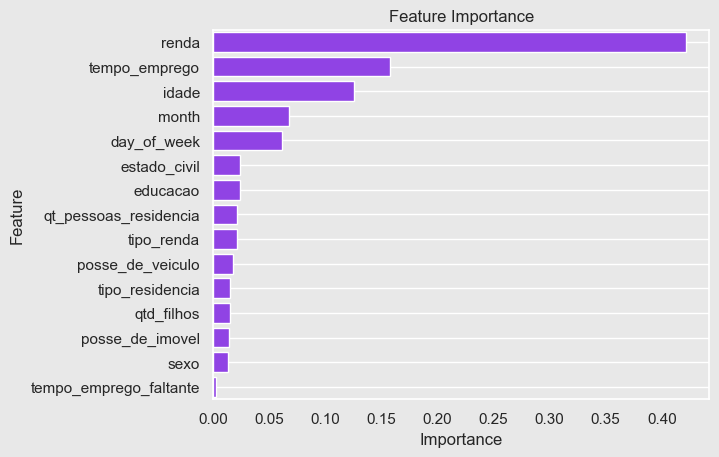

In [11]:
sns.barplot(x='Importance',y='Feature',data=importance.sort_values(by='Importance',ascending=False),color='#8f28ff')
plt.title('Feature Importance')
plt.grid(None)


We can also see through the random forest algorithm the feature importance, how much each variable impacts on decision making.

and below we can see some statistics through a regression, we can see the p-value and the confidence interval 

In [12]:
reg = sm.OLS(y,X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    mau   R-squared (uncentered):              -37591.709
Model:                            OLS   Adj. R-squared (uncentered):         -37593.720
Method:                 Least Squares   F-statistic:                         -1.869e+04
Date:                Tue, 07 Jan 2025   Prob (F-statistic):                        1.00
Time:                        08:20:12   Log-Likelihood:                     -1.1616e+05
No. Observations:              280339   AIC:                                  2.323e+05
Df Residuals:                  280324   BIC:                                  2.325e+05
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
sexo                       0.0544      0.002     34.211      0.000       0.051       0.057
posse_de_veiculo           0.0383      0.002     25.157      0.000       0.035       0.041
posse_de_imovel            0.0340      0.001     23.007      0.000       0.031       0.037
qtd_filhos                -1.4372      0.032    -44.542      0.000      -1.500      -1.374
tipo_renda                 0.0082      0.002      3.561      0.000       0.004       0.013
educacao                   0.1056      0.003     39.112      0.000       0.100       0.111
estado_civil               0.1447      0.003     52.021      0.000       0.139       0.150
tipo_residencia            0.1702      0.004     39.720      0.000       0.162       0.179
idade                      0.1687      0.004     44.295      0.000       0.161       0.176
tempo_emprego              0.0693      0.005     14.952      0.000       0.060       0.078
qt_pessoas_residencia      1.7511      0.027     65.886      0.000       1.699       1.803
renda                     -0.6829      0.007    -93.150      0.000      -0.697      -0.669
month                      0.0160      0.002      7.197      0.000       0.012       0.020
day_of_week                0.0440      0.002     22.631      0.000       0.040       0.048
tempo_emprego_faltante    -0.0470      0.003    -17.407      0.000      -0.052      -0.042
==============================================================================
Omnibus:                    68260.233   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           129935.932
Skew:                           1.593   Prob(JB):                         0.00
Kurtosis:                       3.987   Cond. No.                         95.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
sns.set_palette(sns.color_palette(color_palette))

def cross_validate_classification_models3(X, Y, cv=5):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=10000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        
    }

    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }

    results = {
        'Model': [],
        'Mean Accuracy': [],
        'Mean Precision': [],
        'Mean Recall': [],
        'Mean F1-Score': [],
        'Mean AUC-ROC': []
    }

    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    plt.figure(figsize=(10, 8))
    plt.title("Comparative ROC curves", fontsize=16)
    
    for name, model in models.items():
        print(f"Evaluating {name}...")
        scores = cross_validate(model, X, Y, cv=kf, scoring=scoring, n_jobs=1)

        results['Model'].append(name)
        results['Mean Accuracy'].append(np.mean(scores['test_accuracy']))
        results['Mean Precision'].append(np.mean(scores['test_precision']))
        results['Mean Recall'].append(np.mean(scores['test_recall']))
        results['Mean F1-Score'].append(np.mean(scores['test_f1']))
        results['Mean AUC-ROC'].append(np.mean(scores['test_roc_auc']))

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
        model.fit(X_train, Y_train)
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidade positiva
        
        fpr, tpr, _ = roc_curve(Y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(False)
    plt.show()

    # DataFrame com os resultados
    results_df = pd.DataFrame(results)

    # Melhor modelo
    best_model = results_df.loc[results_df['Mean Accuracy'].idxmax()]
    print("\n Best model based on average accuracy::")
    display(best_model)

    # Barplot das métricas
    metrics = ['Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1-Score', 'Mean AUC-ROC']
    results_df.plot(
        x='Model', 
        y=metrics, 
        kind='bar', 
        figsize=(12, 6), 
        title="Average Model Performance"
    )
    plt.ylabel("Average score", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.grid(None)
    plt.show()
    
    return results_df


In [14]:
X = data_2015_ml.drop(columns=['Unnamed: 0','index','data_ref','mau'])
y = data_2015_ml['mau']

Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating AdaBoost...
Evaluating XGBoost...


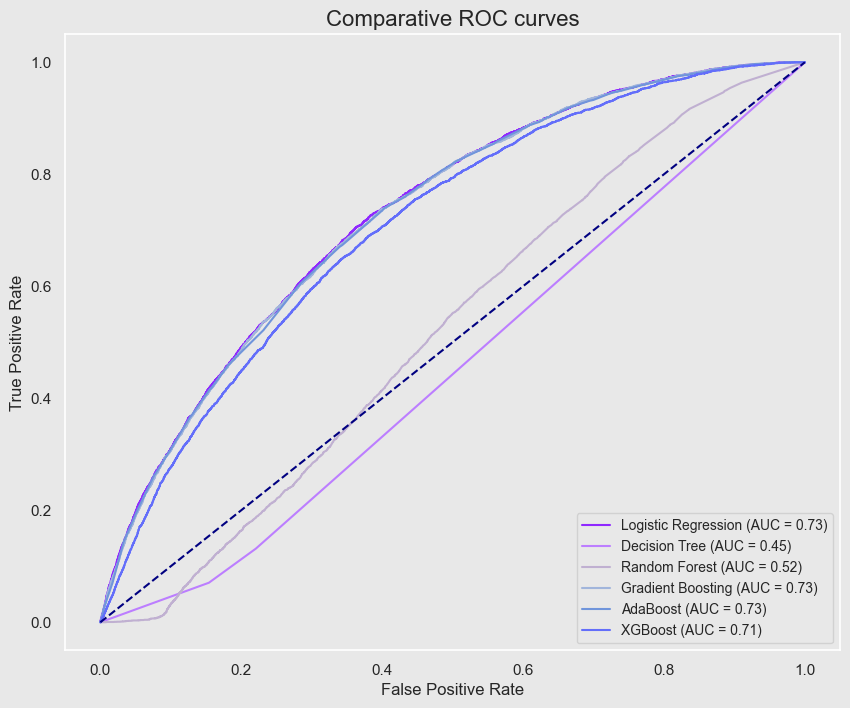


 Best model based on average accuracy::


Model             AdaBoost
Mean Accuracy     0.858558
Mean Precision    0.178788
Mean Recall        0.00213
Mean F1-Score     0.004176
Mean AUC-ROC       0.73174
Name: 4, dtype: object

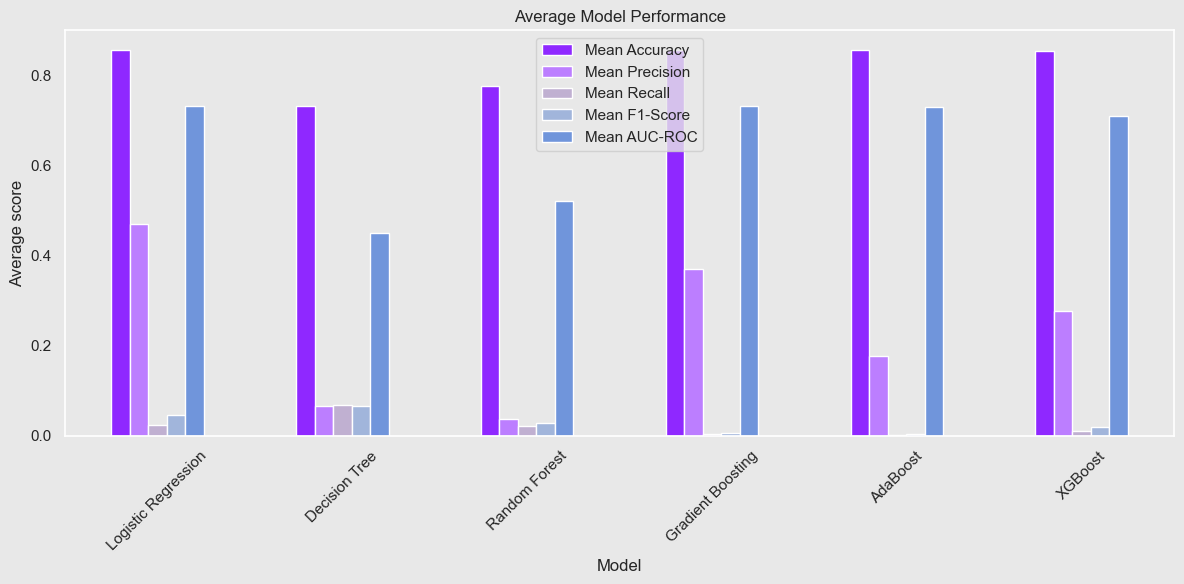

,Model,Mean Accuracy,Mean Precision,Mean Recall,Mean F1-Score,Mean AUC-ROC
0,Logistic Regression,0.858250,0.469997,0.024169,0.045967,0.733982
1,Decision Tree,0.733694,0.066731,0.068108,0.067407,0.450437
2,Random Forest,0.777457,0.036735,0.022780,0.028119,0.523217
3,Gradient Boosting,0.858349,0.371657,0.003750,0.007416,0.732325
4,AdaBoost,0.858558,0.178788,0.002130,0.004176,0.731740
5,XGBoost,0.856333,0.277721,0.010325,0.019901,0.711316


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
cross_validate_classification_models3(X_train,y_train,5)

In [16]:
clf = SGDClassifier()

In [17]:
clf.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [18]:
grid_ = {'alpha':[0.0001,0.1],
              'learning_rate':['optimal'], 'loss':['hinge'],
              'shuffle':[True,False], 'tol':[0.001,1],
              'validation_fraction':[0.1,1]}


grid = RandomizedSearchCV(
    estimator = clf,
    param_distributions=grid_).fit(X_train,y_train)

In [19]:
accuracy = grid.score(X_test, y_test)
y_pred = grid.predict(X_test)
accuracy

0.8612972659410445

In [20]:
print(f"Acuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precisão: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")

Acuracy: 0.86
Precisão: 0.00
Recall: 0.00
F1-Score: 0.00


<div style="background-color:#8f28ff; color:white; padding:10px; border-radius:5px; text-align:center; font-size:20px;">
    Auto ML
</div>

In [21]:
from pycaret.classification import *

exp_clf101 = setup(data = df_, target = 'mau', session_id=123,fix_imbalance=True)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(280339, 19)"
4,Transformed data shape,"(410936, 33)"
5,Transformed train set shape,"(326834, 33)"
6,Transformed test set shape,"(84102, 33)"
7,Numeric features,17
8,Categorical features,1
9,Preprocess,True


In [22]:
best_model = compare_models(fold=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.8328,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,2.8800
lightgbm,Light Gradient Boosting Machine,0.8323,0.7689,0.0648,0.4894,0.1143,0.0783,0.1298,4.7933
gbc,Gradient Boosting Classifier,0.8319,0.7349,0.0205,0.4452,0.0392,0.0248,0.0655,47.2200
xgboost,Extreme Gradient Boosting,0.8296,0.7614,0.1031,0.4579,0.1683,0.1138,0.1541,5.5367
ada,Ada Boost Classifier,0.8209,0.7185,0.1057,0.3735,0.1642,0.0981,0.1230,14.2300
rf,Random Forest Classifier,0.7697,0.5985,0.0608,0.1219,0.0811,-0.0339,-0.0366,23.1000
et,Extra Trees Classifier,0.7561,0.5566,0.0843,0.1344,0.1036,-0.0290,-0.0301,21.6500
dt,Decision Tree Classifier,0.7041,0.5074,0.2119,0.1776,0.1933,0.0138,0.0139,9.0700
lda,Linear Discriminant Analysis,0.6663,0.7490,0.7152,0.2949,0.4176,0.2368,0.2825,3.7033
ridge,Ridge Classifier,0.6662,0.7490,0.7155,0.2948,0.4176,0.2368,0.2826,3.6233


In [23]:
best_model

DummyClassifier(constant=None, random_state=123, strategy='prior')

In [24]:
df = pd.read_feather('credit_scoring.ftr')

In [25]:
dataset = df.sample(50000)

In [26]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data set for modeling (training and test) ' + str(data.shape))
print('Data set not used in training/testing, only as validation:  ' + str(data_unseen.shape))

Data set for modeling (training and test) (47500, 15)
Data set not used in training/testing, only as validation:  (2500, 15)


In [27]:
data

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-05-01,13776,F,N,S,0,Empresário,Superior completo,Solteiro,Casa,45,1.200000,1.0,5077.69,False
1,2016-02-01,10175,F,N,S,0,Empresário,Médio,Casado,Casa,33,7.638356,2.0,2063.34,False
2,2015-12-01,10626,F,S,S,0,Empresário,Médio,Casado,Casa,28,2.010959,2.0,5543.56,False
3,2016-02-01,12874,F,N,S,0,Assalariado,Médio,Casado,Casa,49,9.789041,2.0,5532.67,True
4,2015-01-01,16284,F,N,N,0,Assalariado,Superior incompleto,Casado,Com os pais,38,17.553425,2.0,9101.42,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47495,2016-03-01,534,F,S,S,1,Empresário,Médio,Casado,Casa,41,5.358904,3.0,4544.20,False
47496,2015-11-01,10825,F,N,N,2,Assalariado,Médio,Casado,Casa,39,19.364384,4.0,70807.07,False
47497,2015-12-01,4026,M,S,N,0,Assalariado,Médio,Casado,Casa,25,3.131507,2.0,4278.92,False
47498,2015-01-01,1121,F,N,S,0,Pensionista,Médio,União,Casa,57,NaN,2.0,3077.08,False


In [28]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 15)"
4,Transformed data shape,"(47500, 34)"
5,Transformed train set shape,"(33250, 34)"
6,Transformed test set shape,"(14250, 34)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


In [29]:
best_model = compare_models(fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9201,0.7726,0.0000,0.0000,0.0000,0.0000,0.0000,2.0060
ridge,Ridge Classifier,0.9201,0.6870,0.0000,0.0000,0.0000,0.0000,0.0000,0.2150
lda,Linear Discriminant Analysis,0.9201,0.6869,0.0000,0.0000,0.0000,0.0000,0.0000,0.2850
dummy,Dummy Classifier,0.9201,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1970
ada,Ada Boost Classifier,0.9200,0.7772,0.0456,0.5009,0.0827,0.0703,0.1302,0.9400
gbc,Gradient Boosting Classifier,0.9199,0.7799,0.0354,0.4979,0.0658,0.0556,0.1153,2.3180
lightgbm,Light Gradient Boosting Machine,0.9195,0.7713,0.0373,0.4435,0.0687,0.0572,0.1102,0.4830
xgboost,Extreme Gradient Boosting,0.9168,0.7481,0.0648,0.3771,0.1104,0.0892,0.1292,0.4490
knn,K Neighbors Classifier,0.9118,0.6501,0.0832,0.3129,0.1311,0.1006,0.1260,0.9680
rf,Random Forest Classifier,0.9109,0.7313,0.0640,0.2655,0.1028,0.0739,0.0954,1.4020


In [30]:
best_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
gbc = create_model('gbc')

tuned_gbc = tune_model(gbc, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9197,0.7891,0.0377,0.4545,0.0697,0.0582,0.1130
1,0.9209,0.7476,0.0340,0.5625,0.0641,0.0555,0.1240
2,0.9173,0.7782,0.0377,0.3333,0.0678,0.0524,0.0894
3,0.9209,0.7977,0.0415,0.5500,0.0772,0.0668,0.1351
4,0.9194,0.7794,0.0226,0.4286,0.0429,0.0351,0.0835
5,0.9197,0.7786,0.0451,0.4800,0.0825,0.0697,0.1283
6,0.9197,0.7913,0.0338,0.4737,0.0632,0.0531,0.1100
7,0.9206,0.7872,0.0376,0.5556,0.0704,0.0609,0.1293
8,0.9197,0.7726,0.0338,0.4737,0.0632,0.0531,0.1100


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9203,0.7788,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9203,0.7426,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9203,0.7779,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9203,0.7870,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9200,0.7722,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9200,0.7732,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9200,0.7858,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9200,0.7795,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9200,0.7723,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


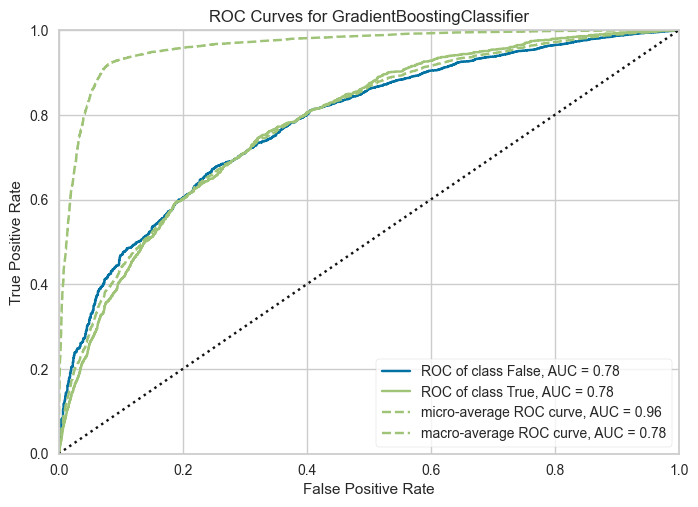

In [32]:
plot_model(tuned_gbc, plot = 'auc')

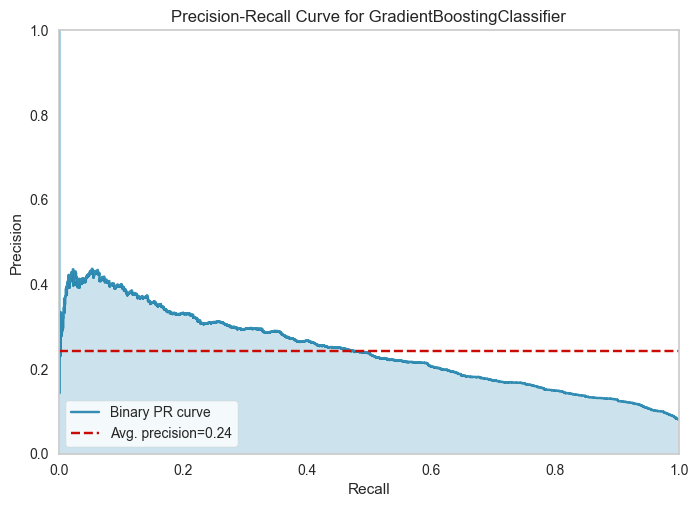

In [33]:
plot_model(tuned_gbc, plot = 'pr')

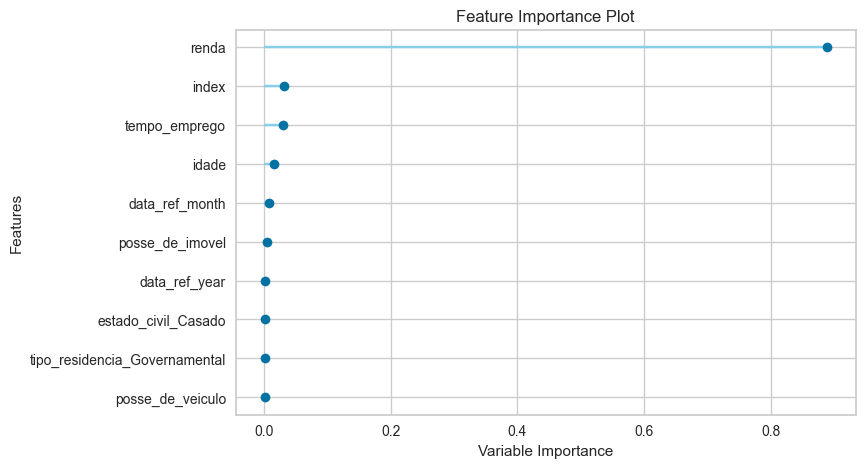

In [34]:
plot_model(tuned_gbc, plot='feature')

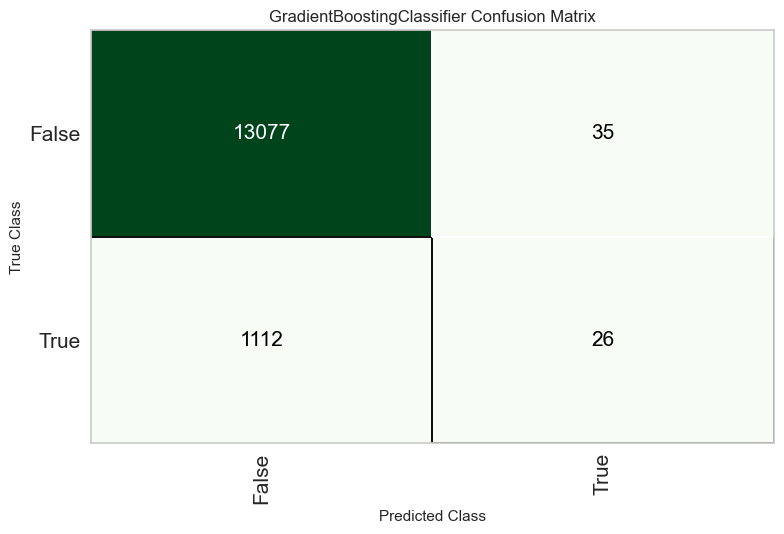

In [35]:
plot_model(tuned_gbc, plot = 'confusion_matrix')

In [36]:
predict_model(tuned_gbc)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9195,0.7811,0.0228,0.4262,0.0434,0.0355,0.0838


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
41357,2015-05-01,4419,M,S,N,0,Pensionista,Médio,União,Casa,60,NaN,2.0,37142.718750,False,0,0.9836
10147,2016-02-01,11261,F,S,N,0,Assalariado,Superior completo,Casado,Casa,32,5.846575,2.0,5306.180176,False,0,0.9435
11065,2016-01-01,1990,M,N,S,1,Assalariado,Médio,Casado,Casa,33,3.008219,3.0,3376.639893,False,0,0.8990
39599,2016-02-01,3570,F,N,S,0,Assalariado,Médio,Casado,Casa,54,12.194521,2.0,9672.480469,False,0,0.9615
46411,2015-09-01,5314,F,S,S,0,Assalariado,Médio,Casado,Casa,33,1.843836,2.0,8727.049805,False,0,0.9608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16404,2015-07-01,4507,F,N,N,0,Assalariado,Médio,Casado,Governamental,45,27.364384,2.0,91189.929688,False,0,0.9916
6598,2015-07-01,14838,M,S,N,0,Empresário,Superior incompleto,Solteiro,Casa,28,5.550685,1.0,38982.449219,False,0,0.9879
2372,2015-10-01,16627,M,S,N,0,Pensionista,Superior completo,Casado,Casa,54,NaN,2.0,4515.790039,False,0,0.9017
3023,2015-09-01,14196,F,S,S,0,Pensionista,Médio,Casado,Casa,47,NaN,2.0,8717.830078,False,0,0.9588


In [37]:
final_gbc = finalize_model(tuned_gbc)

In [55]:
final_gbc

Pipeline(memory=FastMemory(location=C:\Users\User\AppData\Local\Temp\joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['data_ref'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['index', 'qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pesso...
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='log_loss',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
                                            random_state=123, subsample=1.0,
                                            tol=0.0001, validation_fraction=0.1,
                                            verbose=0, warm_start=False))],
         verbose=False)

In [39]:
unseen_predictions = predict_model(final_gbc, data=data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9208,0.7953,0.0203,0.4444,0.0388,0.0322,0.0816


In [40]:
unseen_predictions[unseen_predictions['prediction_label'] == 1]

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
68,2015-01-01,13645,F,N,N,1,Assalariado,Superior completo,Casado,Casa,31,5.183562,3.0,436.899994,True,1,0.6103
283,2016-03-01,14771,F,S,N,0,Assalariado,Médio,Casado,Com os pais,33,0.547945,2.0,522.700012,True,1,0.5101
532,2015-02-01,5301,F,N,S,2,Assalariado,Médio,Casado,Casa,35,0.430137,4.0,341.339996,True,1,0.5736
933,2016-03-01,15385,F,S,N,0,Pensionista,Médio,Casado,Casa,58,NaN,2.0,330.690002,False,1,0.5071
1287,2016-03-01,9471,F,S,N,1,Assalariado,Médio,Casado,Aluguel,37,4.597260,3.0,242.929993,False,1,0.6436
1340,2016-03-01,10744,M,S,N,1,Empresário,Médio,Casado,Casa,25,3.849315,3.0,467.230011,False,1,0.5539
1955,2016-03-01,4873,F,S,S,0,Assalariado,Médio,Casado,Casa,41,0.465753,2.0,388.989990,False,1,0.5375
2048,2016-03-01,4029,M,S,S,2,Assalariado,Médio,Casado,Casa,40,3.213699,4.0,499.920013,True,1,0.5079
2360,2015-10-01,16649,F,N,S,0,Pensionista,Superior completo,Casado,Casa,33,3.630137,2.0,5817.709961,False,1,0.6186


In [41]:
unseen_predictions.dtypes

data_ref                 datetime64[ns]
index                             int32
sexo                           category
posse_de_veiculo               category
posse_de_imovel                category
qtd_filhos                         int8
tipo_renda                     category
educacao                       category
estado_civil                   category
tipo_residencia                category
idade                              int8
tempo_emprego                   float32
qt_pessoas_residencia           float32
renda                           float32
mau                                bool
prediction_label                  int32
prediction_score                float64
dtype: object

In [42]:
save_model(final_gbc,'Final_GBC_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=Sim...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, loss='log_loss',
                                   

In [43]:
final_gbc = load_model('Final_GBC_Model')

Transformation Pipeline and Model Successfully Loaded


In [44]:
df['data_ref'] = pd.to_datetime(df['data_ref'])

In [45]:
scores = final_gbc.predict_proba(df.drop(columns=['mau']))[:, 0]

In [46]:
df['score'] = scores 

In [47]:
df

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,score
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,0.854393
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,0.911641
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,0.664291
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,0.977539
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False,0.898815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False,0.835853
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False,0.752223
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True,0.664792
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True,0.911825
